# Aprendizado de Redimensionamento em Visão Computacional

## Configuração

In [1]:
# Configuração do ambiente e importações necessárias
import os

# Define o backend do Keras como TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import ops
from keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds

# Desabilita barra de progresso do tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np

## Definir hiperparâmetros

Para facilitar o aprendizado em mini-lotes, precisamos ter uma forma fixa para as imagens
dentro de um determinado lote. É por isso que um redimensionamento inicial é necessário. Primeiro redimensionamos todas
as imagens para a forma (300 x 300) e então aprendemos sua representação ótima para a
resolução (150 x 150).

In [2]:
# Tamanho de entrada das imagens (resolução inicial)
INP_SIZE = (300, 300)
# Tamanho alvo após redimensionamento aprendível
TARGET_SIZE = (150, 150)
# Método de interpolação
INTERPOLATION = "bilinear"

# Configurações de treinamento
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64  # Tamanho do lote
EPOCHS = 5       # Número de épocas

Neste exemplo, se faz uso a interpolação bilinear, mas o módulo de redimensionamento de imagem aprendível
não depende de nenhum método de interpolação específico. Também podemos usar outros,
como bicúbico.

## Carregar e preparar o conjunto de dados

Para este exemplo, usaremos apenas 40% do conjunto de dados de treinamento total.

In [3]:
# Carrega o conjunto de dados cats_vs_dogs do TensorFlow Datasets
train_ds, validation_ds = tfds.load(
    "cats_vs_dogs",
    # Reserva 10% para validação (40% a 50% do dataset total)
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,
)


def preprocess_dataset(image, label):
    """
    Função de pré-processamento das imagens e rótulos
    - Redimensiona imagem para o tamanho de entrada
    - Converte rótulo para codificação one-hot
    """
    image = ops.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))
    label = ops.one_hot(label, num_classes=2)
    return (image, label)


# Prepara conjunto de dados de treinamento
train_ds = (
    train_ds.shuffle(BATCH_SIZE * 100)  # Embaralha os dados
    .map(preprocess_dataset, num_parallel_calls=AUTO)  # Aplica pré-processamento
    .batch(BATCH_SIZE)  # Cria lotes
    .prefetch(AUTO)     # Otimiza carregamento
)

# Prepara conjunto de dados de validação
validation_ds = (
    validation_ds.map(preprocess_dataset, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.



![](https://i.ibb.co/gJYtSs0/image.png)

In [4]:
def conv_block(x, filters, kernel_size, strides, activation=layers.LeakyReLU(0.2)):
    """
    Bloco de convolução básico com normalização em lote
    """
    x = layers.Conv2D(filters, kernel_size, strides, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    return x


def res_block(x):
    """
    Bloco residual para aprendizado de características refinadas
    """
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation=None)
    return layers.Add()([inputs, x])

    # Nota: o usuário pode alterar num_res_blocks para >1 também se necessário


def get_learnable_resizer(filters=16, num_res_blocks=1, interpolation=INTERPOLATION):
    """
    Constrói o módulo de redimensionamento aprendível

    Args:
        filters: Número de filtros nas camadas convolucionais
        num_res_blocks: Número de blocos residuais
        interpolation: Método de interpolação

    Returns:
        Modelo Keras do redimensionador aprendível
    """
    inputs = layers.Input(shape=[None, None, 3])

    # Primeiro, realiza redimensionamento ingênuo (baseline)
    naive_resize = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(inputs)

    # Primeiro bloco de convolução sem normalização em lote
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Segundo bloco de convolução com normalização em lote
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Redimensionamento intermediário como gargalo
    bottleneck = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(x)

    # Passagens residuais
    # Primeiro res_block receberá a saída do bottleneck como entrada
    x = res_block(bottleneck)
    # Os res_blocks restantes receberão a saída do res_block anterior como entrada
    for _ in range(num_res_blocks - 1):
        x = res_block(x)

    # Projeção final
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    # Conexão de salto (skip connection)
    x = layers.Add()([bottleneck, x])

    # Imagem redimensionada final
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return keras.Model(inputs, final_resize, name="learnable_resizer")


# Cria instância do redimensionador aprendível
learnable_resizer = get_learnable_resizer()

## Visualizar as saídas do módulo de redimensionamento aprendível

Aqui, visualizamos como as imagens redimensionadas ficariam após serem passadas pelos
pesos aleatórios do redimensionador.

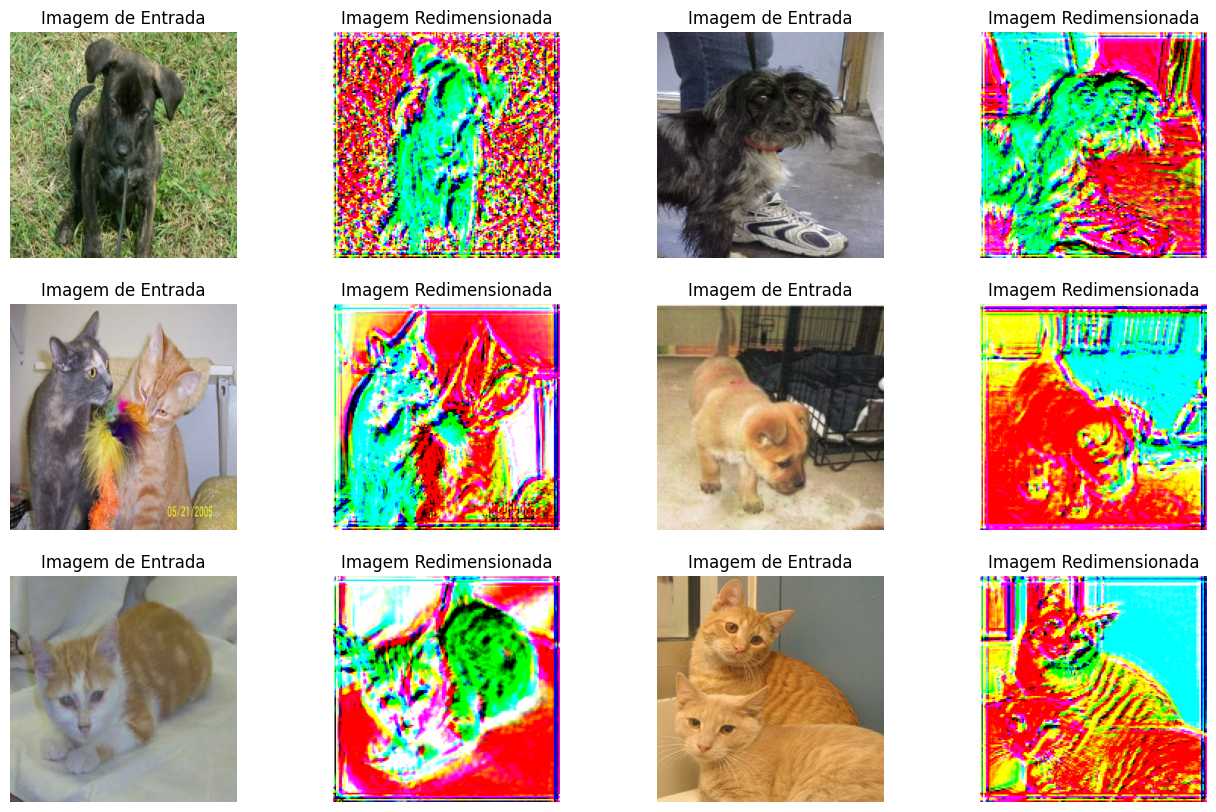

In [5]:
# Obtém amostras de imagens do conjunto de treinamento
sample_images, _ = next(iter(train_ds))

# Cria visualização comparativa das imagens originais e redimensionadas
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    # Normaliza a imagem para o intervalo [0, 1]
    image = image / 255

    # Mostra imagem original
    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Imagem de Entrada")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    # Mostra imagem redimensionada pelo módulo aprendível
    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Imagem Redimensionada")
    plt.imshow(resized_image.numpy().squeeze())
    plt.axis("off")

## Utilitário de construção do modelo

In [6]:
def get_model():
    """
    Constrói o modelo completo integrando o redimensionador aprendível
    com a arquitetura DenseNet-121

    Returns:
        Modelo Keras completo
    """
    # Carrega a arquitetura DenseNet-121 sem pesos pré-treinados
    backbone = keras.applications.DenseNet121(
        weights=None,           # Sem pesos pré-treinados
        include_top=True,       # Inclui camadas de classificação
        classes=2,              # 2 classes (gatos e cachorros)
        input_shape=((TARGET_SIZE[0], TARGET_SIZE[1], 3)),  # Forma de entrada
    )
    backbone.trainable = True

    # Constrói o pipeline completo
    inputs = layers.Input((INP_SIZE[0], INP_SIZE[1], 3))     # Entrada original
    x = layers.Rescaling(scale=1.0 / 255)(inputs)           # Normalização [0,1]
    x = learnable_resizer(x)                                 # Redimensionamento aprendível
    outputs = backbone(x)                                    # Classificação DenseNet

    return keras.Model(inputs, outputs)

A estrutura do módulo de redimensionamento de imagem aprendível permite integrações flexíveis com
diferentes modelos de visão.

## Compilar e treinar nosso modelo com redimensionador aprendível

In [7]:
# Cria e compila o modelo
model = get_model()
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Perda com suavização de rótulos
    optimizer="sgd",        # Otimizador SGD
    metrics=["accuracy"],   # Métrica de acurácia
)

# Treina o modelo
model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS)

Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.5737 - loss: 0.6951 - val_accuracy: 0.5052 - val_loss: 0.7001
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 79s 497ms/step - accuracy: 0.6145 - loss: 0.6728 - val_accuracy: 0.5082 - val_loss: 0.7305
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.6349 - loss: 0.6542 - val_accuracy: 0.5215 - val_loss: 0.8136
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 86s 547ms/step - accuracy: 0.6687 - loss: 0.6297 - val_accuracy: 0.4832 - val_loss: 0.9604
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 135s 505ms/step - accuracy: 0.6800 - loss: 0.6150 - val_accuracy: 0.5684 - val_loss: 0.7676


## Visualizar as saídas do visualizador treinado

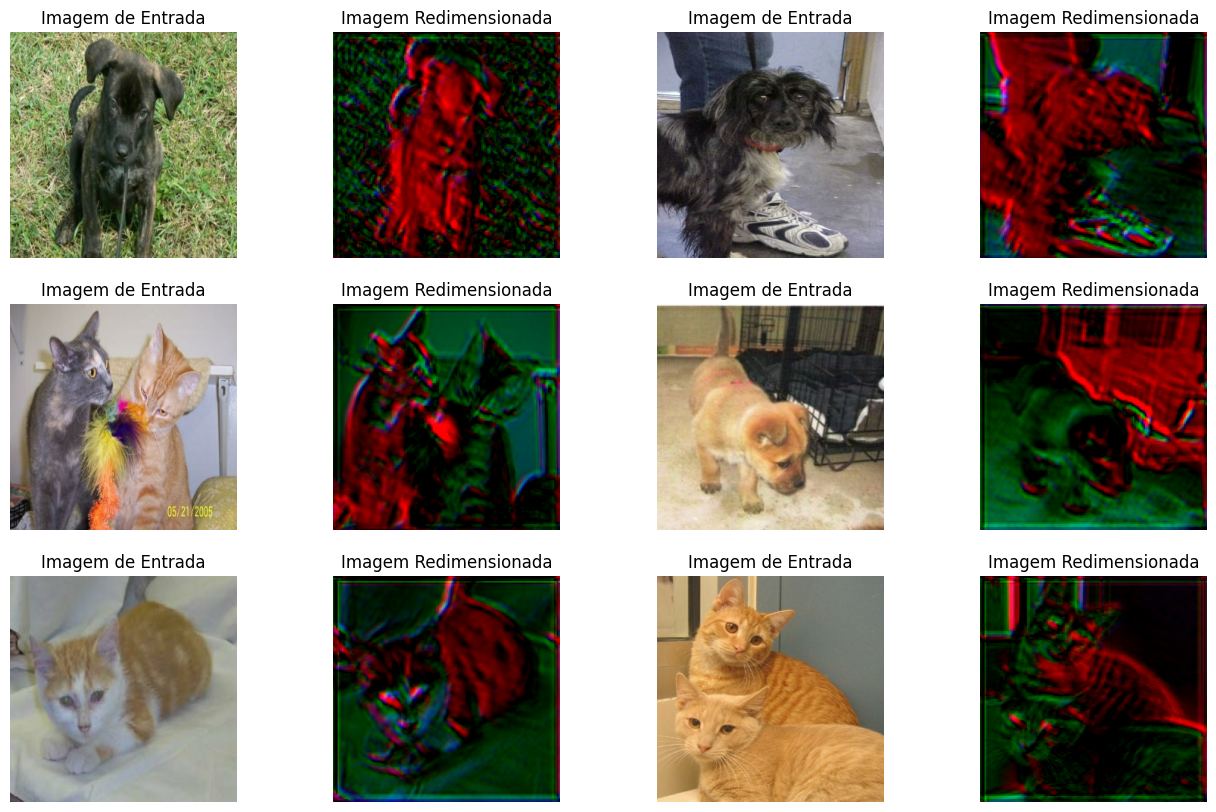

In [8]:
# Visualiza as saídas do redimensionador após o treinamento
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    # Normaliza a imagem
    image = image / 255

    # Mostra imagem original
    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Imagem de Entrada")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    # Mostra imagem redimensionada pelo módulo treinado
    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Imagem Redimensionada")
    plt.imshow(resized_image.numpy().squeeze() / 10)  # Normalização adicional para visualização
    plt.axis("off")